# Model odpływu klientów
Zbiór danych w tym projekcie dotyczy użytkowników kart kredytowych w banku. Zarząd banku chce poznać jakie czynniki klientów mogą wpływać na odejście klientów z banku. Dlatego zarząd postanowił zrobić model, który będzie przewidywał negatywne dla banku zachowania klienta.

Importujemy wszystkie niezbędne biblioteki dla przeróbki danych, wizualizacji i potrzebnych modeli predykcyjnych.

In [1]:
#Praca z danymi
import pandas as pd
import numpy as np
import scipy as sp
#Wizualizacja
import matplotlib.pyplot as plt
import seaborn as sns
#Scikit-learn
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score
#Modele
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier

pd.set_option("precision", 5)

## Eksploracja liczbowa danych
Wczytujemy dane i sprawdzamy niezbędne informacje o tych danych.

In [2]:
data = pd.read_csv("BankChurners.csv")

shape = data.shape
am_num = len(data.select_dtypes(exclude="object").columns)
am_obj = len(data.select_dtypes(exclude=("int64","float64")).columns) 

print("Rozmiar danych: ", shape,
     "\nIlość kolumn numerycznych: ", am_num,
     "\nIlość kolumn tekstowych: ", am_obj)

Rozmiar danych:  (10127, 23) 
Ilość kolumn numerycznych:  17 
Ilość kolumn tekstowych:  6


Z zaciągniętych danych widzimy, że
* dane mają 23 kolumny i 10127 wierszy
* dane mają zmienne numeryczne jak i tekstowe
* dane mają niepotrzebne pierwsą i dwie ostatnie kolumny

Dalej chcemy się dowiedzieć czy są wartości brakujące i zduplikowane w danych.

In [3]:
NA_val = data.isnull().sum().sum()
DB_val = data.duplicated().sum()

print("Ilość wartości brakujących: ", NA_val,
     "\nIlość wartości zduplikowanych: ", DB_val)

Ilość wartości brakujących:  0 
Ilość wartości zduplikowanych:  0


Z wyników widać, że dane nie mają wartości brakujących i zduplikowanych, co jest dla nas sytuacją korzystną. Dalej usuniemy zbędne zmienne, które nie niosą żadnej informacji, czyli pierwszą i ostatnie dwie kolumny.

In [4]:
data = data.iloc[:,1:-2]

Teraz sprawdzimy krótki opis statystyczny analizowanych danych. Najpierw statystyki opisowe podamy dla zmiennych numerycznych. 

In [5]:
data.describe(exclude="object")

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
count,10127.00000,10127.00000,10127.00000,10127.00000,10127.00000,10127.00000,10127.00000,10127.00000,10127.00000,10127.00000,10127.00000,10127.00000,10127.00000,10127.00000
mean,46.32596,2.34620,35.92841,3.81258,2.34117,2.45532,8631.95370,1162.81406,7469.13964,0.75994,4404.08630,64.85869,0.71222,0.27489
std,8.01681,1.29891,7.98642,1.55441,1.01062,1.10623,9088.77665,814.98734,9090.68532,0.21921,3397.12925,23.47257,0.23809,0.27569
min,26.00000,0.00000,13.00000,1.00000,0.00000,0.00000,1438.30000,0.00000,3.00000,0.00000,510.00000,10.00000,0.00000,0.00000
25%,41.00000,1.00000,31.00000,3.00000,2.00000,2.00000,2555.00000,359.00000,1324.50000,0.63100,2155.50000,45.00000,0.58200,0.02300
50%,46.00000,2.00000,36.00000,4.00000,2.00000,2.00000,4549.00000,1276.00000,3474.00000,0.73600,3899.00000,67.00000,0.70200,0.17600
75%,52.00000,3.00000,40.00000,5.00000,3.00000,3.00000,11067.50000,1784.00000,9859.00000,0.85900,4741.00000,81.00000,0.81800,0.50300
max,73.00000,5.00000,56.00000,6.00000,6.00000,6.00000,34516.00000,2517.00000,34516.00000,3.39700,18484.00000,139.00000,3.71400,0.99900


Przejrząc statystyki dla zmiennych numerycznych nie zauważamy żadnych anomalii w danych. Teraz spójrzmy na opis zmiennych tekstowych/kategoryjnych i dodatkowo na zmienną numeryczną 'Customer_Age' chcąc popatrzeć na tę zmienną z punktu widzenia wieku jako kategorii.

In [6]:
#count_age = (data["Customer_Age"]==max(list(data["Customer_Age"]),key = list(data["Customer_Age"]).count)).sum()
def m_freq(dane):
    
    un = sorted(pd.unique(dane))
    df = pd.Series(np.repeat(0,len(un)),index=[un])
    l = -1
    
    for i in un:
        l+=1
        for j in dane:
            if (j==i):
                df.iloc[l]+=1
    return pd.DataFrame((len(dane), len(un), 
                         int(df.idxmax()[0]), max(df), 
                         round(max(df)/len(dane),2)),
                        index=["count","unique","top","freq","conc"])

cust_age_st = m_freq(data["Customer_Age"])
#cust_age_st.columns = ["Customer_Age"]

df_cat = data.describe(exclude=("int64","float64"))
df_conc_cat = ((df_cat.iloc[3,]/df_cat.iloc[0,])*100).astype(float).round(2)
df_cat = df_cat.append(df_conc_cat, ignore_index=True)
ind = ["count", "unique", "top", "freq", "conc"]
df_cat = df_cat.set_index([ind])
df_cat["Customer_Age"] = cust_age_st.values.astype("object")
df_cat.iloc[4,6] = round(df_cat.iloc[3,6]/df_cat.iloc[0,6],2)
df_cat.iloc[4,] = df_cat.iloc[4,].astype(str) + '%'

df_cat

,Attrition_Flag,Gender,Education_Level,Marital_Status,Income_Category,Card_Category,Customer_Age
count,10127,10127,10127,10127,10127,10127,10127
unique,2,2,7,4,6,4,45
top,Existing Customer,F,Graduate,Married,Less than $40K,Blue,44
freq,8500,5358,3128,4687,3561,9436,500
conc,83.93%,52.91%,30.89%,46.28%,35.16%,93.18%,0.05%


Patrząc na liczbowy opis zmiennych kategorycznych można dostrzec, że jest przeważająca koncentracja (83.93%) naszej zmiennej 'Attrition_Flag' w klientach, którzy są aktywni i posiadają konto w banku. Tę zmienną my będziemy używać dla przewidywania budując modeli predykcyjne, dlatego taką informację należy będzie wziąć pod uwagę, aby model nauczyć na danych odpowiednio. W przeciwnym wypadku model będzie nie reprezentatywny i na nowych danych będzie robił więcej fałszywych predykcji. Pod uwagę należy też wziąć zmienną 'Card_Category', ponieważ będzie ta zmienna objaśniającą w modelu i koncentracja 93.18% w ofercie niebieskiej karty dla tej zmiennej może być niedobra, powodując bezsensowność. Co dotyczy zmiennej 'Customer_Age' to klienci są głównie skoncentrowani w grupie wiekowej 44 lata, ale ta koncentracja jest niewielka w porównaniu z innymi grupami wiekowymi.

## Eksploracja wizualizacyjna danych
W tym podrozdziale chcemy popatrzeć na dane na wykresach i zrobić odpowiednie wnioski.
### Wizualizacja danych numerycznych
Przed wizualizacją przekształcimy naszą zmienną docelową do postaci (0, 1), gdzie 0 to klient aktywny posiadający konto; 1 nieaktywny, który konto zamknał.

In [7]:
data["Attrition_Flag"] = np.where(data["Attrition_Flag"].str.contains("Existing Customer"), 0, 1)
pd.unique(data["Attrition_Flag"])

array([0, 1])

Wygenerujemy wykresy gęstości i pudełkowe dla danych, żeby zobaczyć jak się zmienne zachowują przy podziale na klientów, którzy są nadal klientami i tych którzy zamknęli konta. Pokażemy też wartości ekstremalnie odstające, ilość których zgenerowana będzie niżej dla każdej ze zmiennych. Ale jednak trzeba zauważyć, że przy rozważanym typie analizowanego problemu (danych bankowych) wartości odstające będą istniały i będzie ich dość dużo.

0 wartości ekstremalnie odstających zmiennej  Customer_Age
0 wartości ekstremalnie odstających zmiennej  Dependent_count
0 wartości ekstremalnie odstających zmiennej  Months_on_book
0 wartości ekstremalnie odstających zmiennej  Total_Relationship_Count
124 wartości ekstremalnie odstających zmiennej  Months_Inactive_12_mon
54 wartości ekstremalnie odstających zmiennej  Contacts_Count_12_mon
0 wartości ekstremalnie odstających zmiennej  Credit_Limit
0 wartości ekstremalnie odstających zmiennej  Total_Revolving_Bal
0 wartości ekstremalnie odstających zmiennej  Avg_Open_To_Buy
90 wartości ekstremalnie odstających zmiennej  Total_Amt_Chng_Q4_Q1
737 wartości ekstremalnie odstających zmiennej  Total_Trans_Amt
0 wartości ekstremalnie odstających zmiennej  Total_Trans_Ct
80 wartości ekstremalnie odstających zmiennej  Total_Ct_Chng_Q4_Q1
0 wartości ekstremalnie odstających zmiennej  Avg_Utilization_Ratio


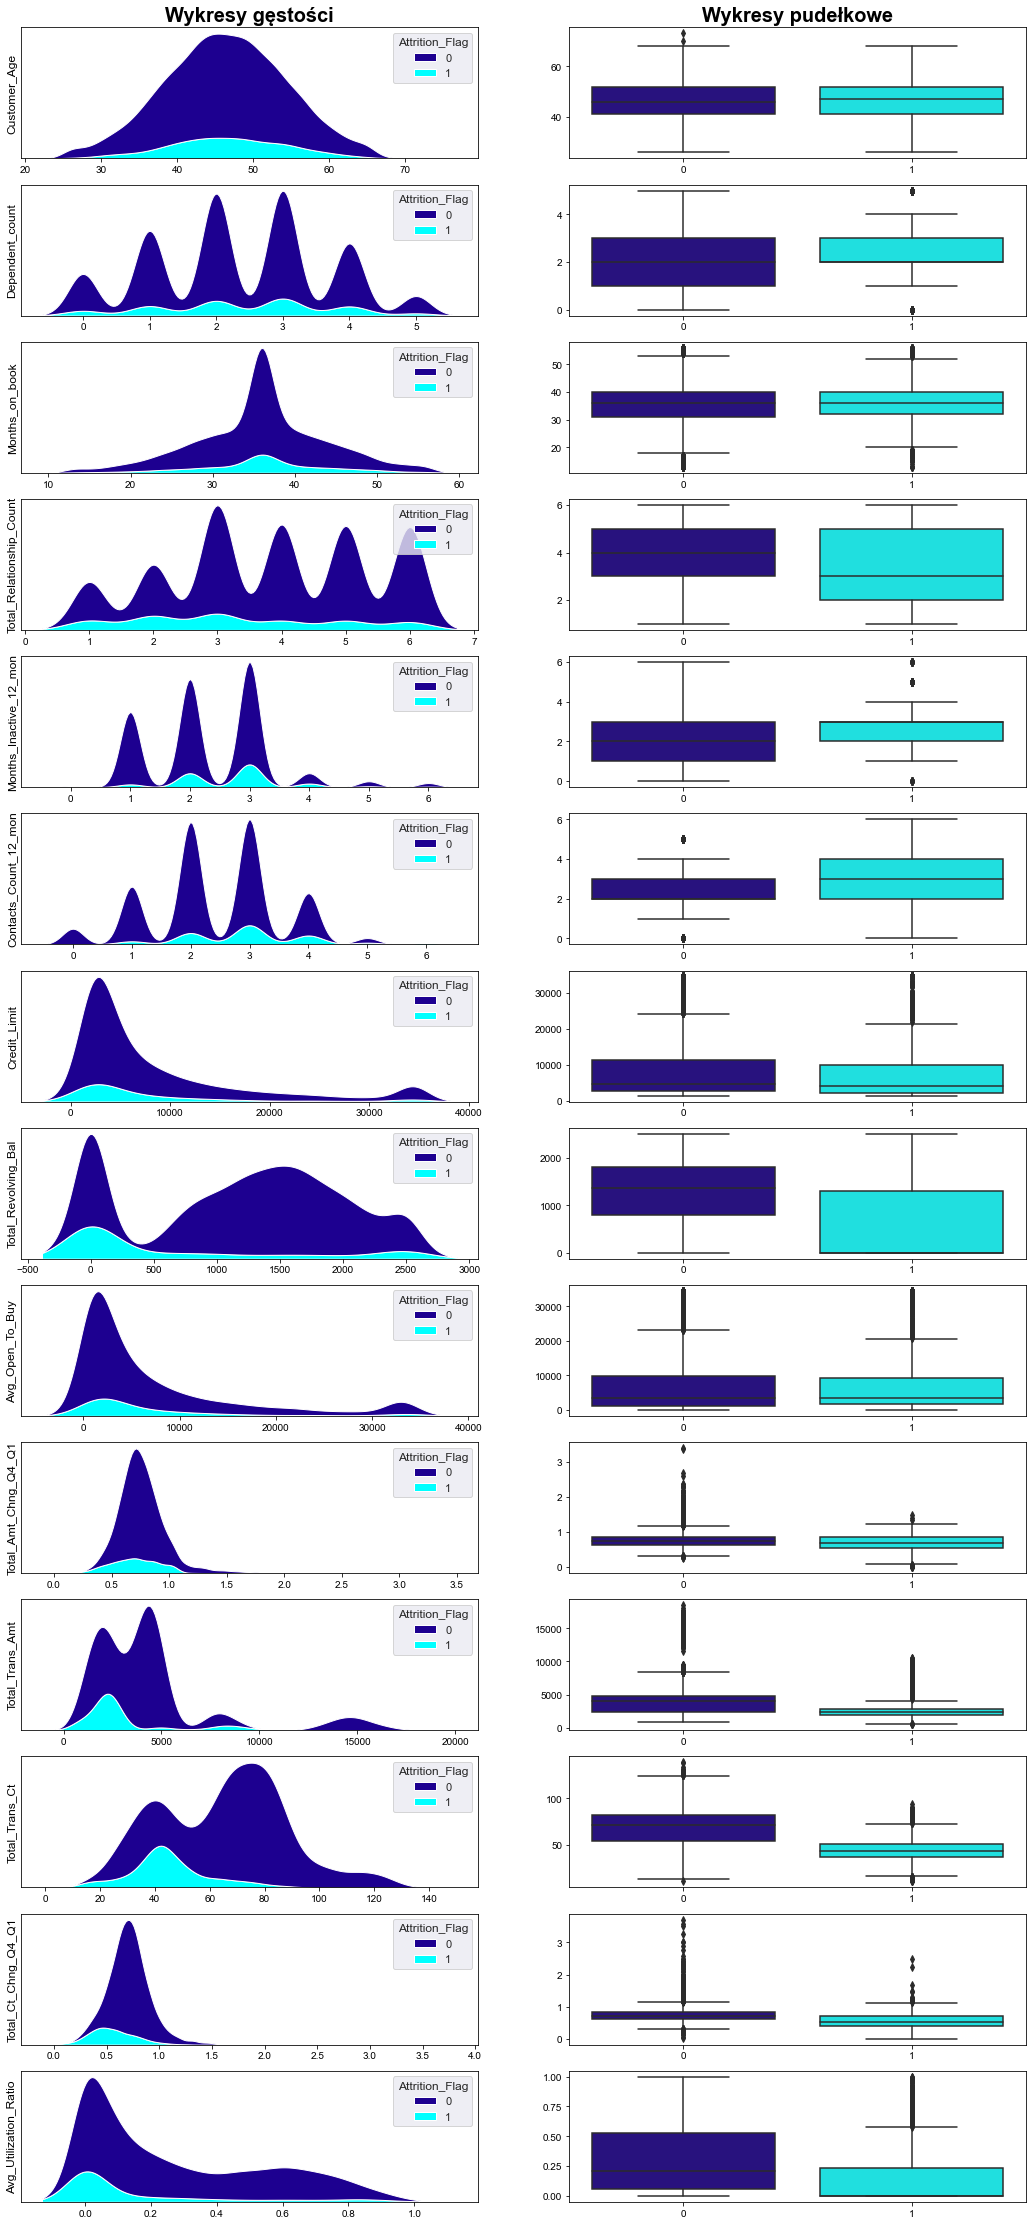

In [8]:
#data.dtypes
data_num = data.select_dtypes(include=['int32', 'int64', 'float64'])

def otl_det(dane):
    for col in np.arange(1,len(dane.columns)):
        q1, q3 = dane.iloc[:,col].quantile(0.25), dane.iloc[:,col].quantile(0.75)
        iqr = q3 - q1
        low, up = (q1 - 3 * iqr), (q3 + 3 * iqr)
        count=pd.Series(dane[(dane.iloc[:,col]<=low) | (dane.iloc[:,col]>=up)].index).count()
        print(count, "wartości ekstremalnie odstających zmiennej ",dane.columns[col])
        
otl_det(data_num)        

fig, ax = plt.subplots(ncols=2, nrows=14, figsize=(18, 40))

def plot_many_num(dane):
    
    col_nam = dane.columns
    for column in np.arange(1,len(dane.columns)):
        
        sns.set_theme(style="dark",font_scale=1)
        sns.kdeplot(data=dane, x = dane.iloc[:,column], hue="Attrition_Flag",
                    fill=True,palette=["#1D0090", "#00FFFF"],multiple='stack',
                    alpha=1,ax=ax[column-1,0])
        
        sns.boxplot(data=dane, x="Attrition_Flag",y=dane.iloc[:,column],
                    palette=["#1D0090", "#00FFFF"],ax=ax[column-1,1])
        
        ax[column-1,0].set_xlabel(' ')
        ax[column-1,1].set_xlabel(' ')
        ax[column-1,1].set_ylabel(' ')
        ax[column-1,0].set_ylabel(col_nam[column], fontsize=12)
        ax[0,0].set_title("Wykresy gęstości", fontsize=20)
        ax[0,0].set_title("Wykresy gęstości", fontsize=20, fontweight='bold')
        ax[0,1].set_title("Wykresy pudełkowe", fontsize=20, fontweight='bold')
        ax[column-1,0].tick_params(left=False, labelleft=False)
            
            
plot_many_num(data_num)

Z wykresów z szerokimi ogonami po prawej stronie i tabelki widać rzeczywiście, że niektóre zmienne pokazują dużą dyspersję. Popatrzmy teraz na korelację pomiędzy zmiennymi numerycznymi.

Text(0.5, 1.0, 'Korelacja Pearsona wśród zmiennych numerycznych')

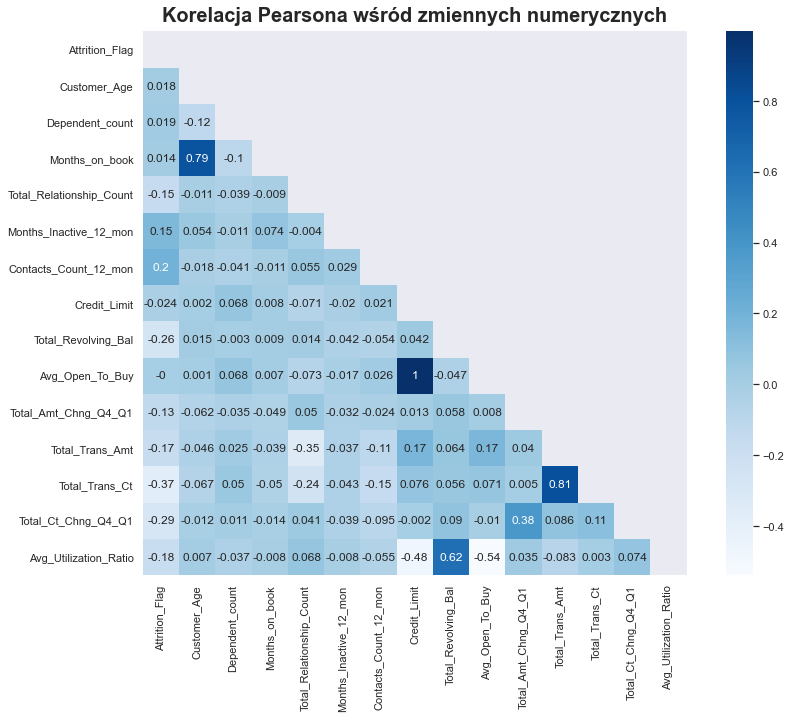

In [9]:
cor_data = round(data_num.corr(method='pearson'),3)
plt.figure(figsize=[14,10])
mask = np.zeros_like(cor_data)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(cor_data,annot=True,cmap='Blues',
            square=True,mask=mask).set_title("Korelacja Pearsona wśród zmiennych numerycznych",
                                             fontsize=20, fontweight='bold', pad=10)

Z wyników widać, że większość zmiennych nie jest między sobą skorelowana. Chociaż niektóre zmienne z oczywistych względów ma wysoką korelację.

### Wizualizacja danych kategoryjnych

C:\Users\HP\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


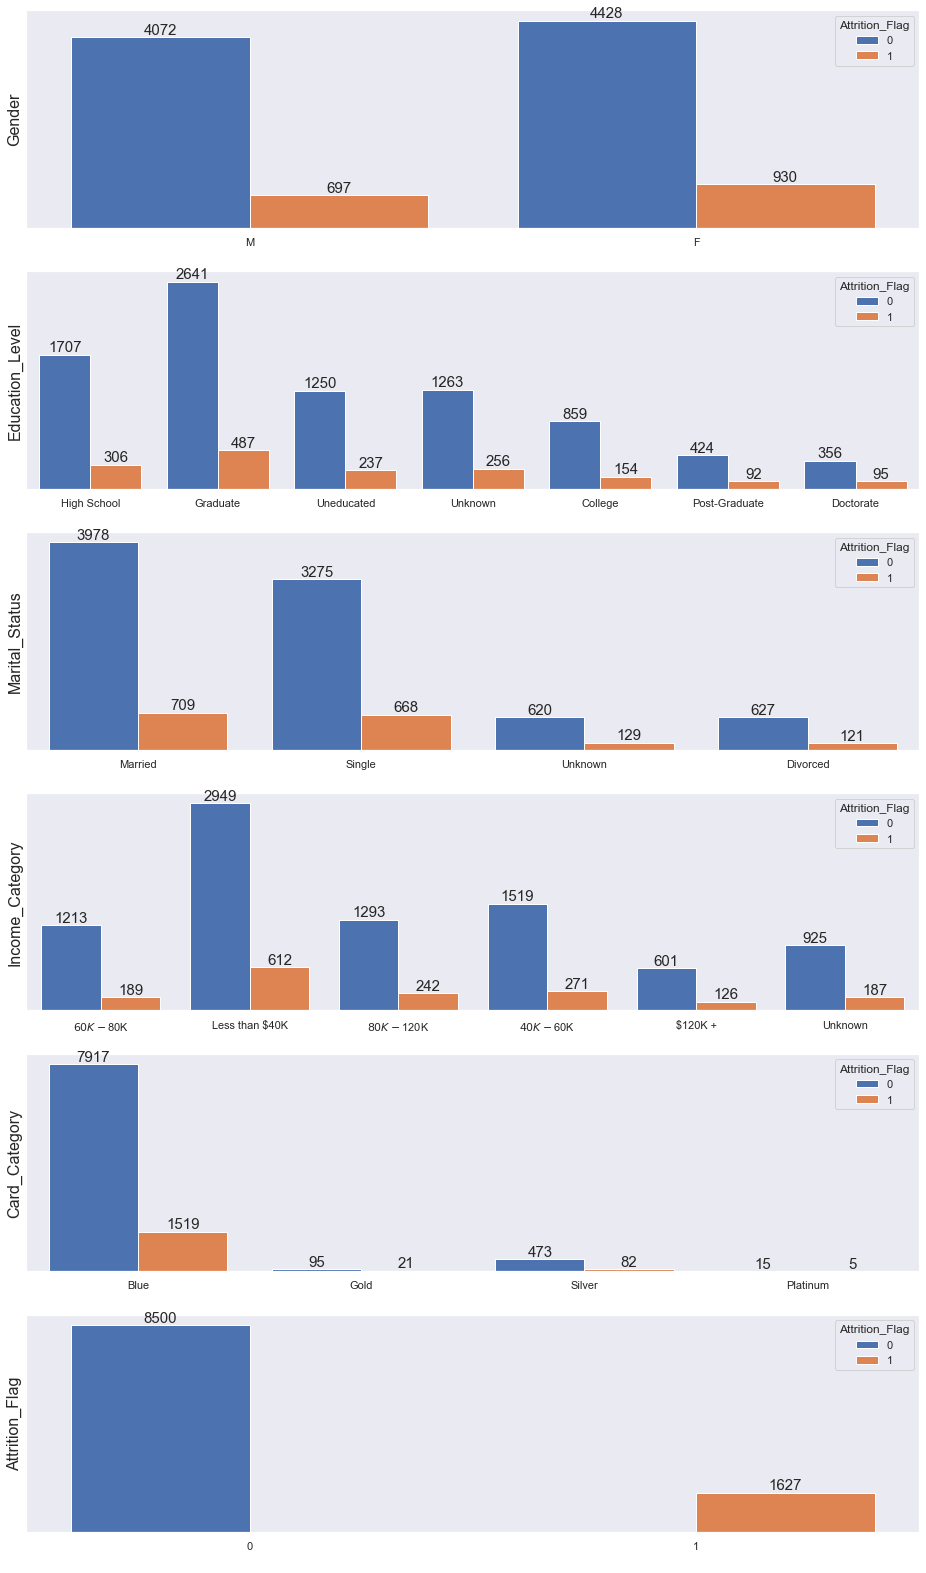

In [10]:
data_cat = data.select_dtypes(include=['object'])
data_cat["Attrition_Flag"] = data.loc[:,"Attrition_Flag"] 

fig, ax = plt.subplots(ncols=1, nrows=6, figsize=(16, 28))

def plot_many_cat(dane):
    
    sns.set_theme(style="dark",font_scale=1)
    col_cat = dane.columns
    for column in np.arange(0,len(dane.columns)):
        sns.countplot(x=dane.iloc[:,column], hue=dane['Attrition_Flag'], 
                    saturation=1, alpha=1, ax=ax[column])
        
        ax[column].bar_label(ax[column].containers[0], size="15")
        ax[column].bar_label(ax[column].containers[1], size="15")
        ax[column].tick_params(left=False, labelleft=False)
        ax[column].set_xlabel(' ')
        ax[column].set_ylabel(' ')
        ax[column].set_ylabel(col_cat[column], fontsize=16)
        

plot_many_cat(data_cat)

### Modelowanie
Przekodujemy wszystkie zmienne tekstowe, przy czym zmienne odzwierciedlające poziomy przekształcimy do postaci 1...n; inne tekstowe przekształcimy do dummysów. W taki sposób model będzie odpowiednio traktował te zmienne. 

In [11]:
ord_enc_inc = OrdinalEncoder(categories=[['Unknown','Less than $40K','$40K - $60K','$60K - $80K','$80K - $120K','$120K +']])
data.loc[:,["Income_Category"]] = ord_enc_inc.fit_transform(data.loc[:,["Income_Category"]])
ord_enc_edu = OrdinalEncoder(categories=[['Unknown','Uneducated','High School','College','Graduate','Post-Graduate','Doctorate']])
data.loc[:,["Education_Level"]] = ord_enc_edu.fit_transform(data.loc[:,["Education_Level"]])
ord_enc_card = OrdinalEncoder(categories=[['Blue','Silver','Gold','Platinum']])
data.loc[:,["Card_Category"]] = ord_enc_card.fit_transform(data.loc[:,["Card_Category"]])

ca = data.select_dtypes(include='object').columns
data = pd.get_dummies(data, columns = ca, drop_first=True)
data

,Attrition_Flag,Customer_Age,Dependent_count,Education_Level,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,...,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Gender_M,Marital_Status_Married,Marital_Status_Single,Marital_Status_Unknown
0,0,45,3,2.0,3.0,0.0,39,5,1,3,...,11914.0,1.335,1144,42,1.625,0.061,1,1,0,0
1,0,49,5,4.0,1.0,0.0,44,6,1,2,...,7392.0,1.541,1291,33,3.714,0.105,0,0,1,0
2,0,51,3,4.0,4.0,0.0,36,4,1,0,...,3418.0,2.594,1887,20,2.333,0.000,1,1,0,0
3,0,40,4,2.0,1.0,0.0,34,3,4,1,...,796.0,1.405,1171,20,2.333,0.760,0,0,0,1
4,0,40,3,1.0,3.0,0.0,21,5,1,0,...,4716.0,2.175,816,28,2.500,0.000,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,0,50,2,4.0,2.0,0.0,40,3,2,3,...,2152.0,0.703,15476,117,0.857,0.462,1,0,1,0
10123,1,41,2,0.0,2.0,0.0,25,4,2,3,...,2091.0,0.804,8764,69,0.683,0.511,1,0,0,0
10124,1,44,1,2.0,1.0,0.0,36,5,3,4,...,5409.0,0.819,10291,60,0.818,0.000,0,1,0,0
10125,1,30,2,4.0,2.0,0.0,36,4,3,3,...,5281.0,0.535,8395,62,0.722,0.000,1,0,0,1


Podzielimy teraz nazse gotowe do modelowania dane na zbiór uczący i testowy odpowiednio dzieląc flagę docelową. Przy czym normalizujemy dane numeryczne, aby zniwelować wpływ wcześniej zauważonych outlierów. Na danych uczących będzie trenować model, na danych testowych sprawdzać wydajność i ewentualne problemy overfittingu/underfittingu.

In [13]:
y = data.pop("Attrition_Flag")
X = data

X_tr, X_te, y_tr, y_te = train_test_split(X, y, train_size=0.7, random_state=69, stratify=y)

numm_cols = ['Customer_Age', 'Dependent_count', 'Months_on_book', 'Total_Relationship_Count','Months_Inactive_12_mon',
            'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal','Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 
            'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1','Avg_Utilization_Ratio']

scaler = StandardScaler()

X_tr.loc[:,numm_cols] = scaler.fit_transform(X_tr.loc[:,numm_cols])

X_te.loc[:,numm_cols] = scaler.transform(X_te.loc[:,numm_cols])

pd.DataFrame(X_tr)

C:\Users\HP\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\HP\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,Customer_Age,Dependent_count,Education_Level,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,...,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Gender_M,Marital_Status_Married,Marital_Status_Single,Marital_Status_Unknown
2332,1.32798,0.51151,2.0,0.0,0.0,0.01048,-1.80939,1.64409,-0.40178,-0.02464,...,-0.11273,-1.71234,-0.89973,-1.13624,-1.25603,-0.15304,0,0,1,0
6845,-0.78657,1.28291,3.0,4.0,0.0,-0.61065,1.40811,-0.33255,0.50229,0.82224,...,0.94986,0.03777,-0.19897,-0.11591,-0.82462,-1.00188,1,0,0,0
634,2.32307,-1.03129,1.0,2.0,0.0,2.49501,-0.52239,0.65577,-0.40178,-0.67918,...,-0.77341,0.65438,-0.76380,-0.79613,-0.52058,1.96907,1,1,0,0
7147,0.70606,-0.25989,0.0,1.0,0.0,0.01048,1.40811,0.65577,-1.30584,-0.68106,...,-0.74348,-0.17080,0.25959,1.07449,-0.06041,1.56278,0,1,0,0
3764,1.94991,-1.03129,2.0,2.0,0.0,2.49501,-0.52239,2.63241,-1.30584,-0.53116,...,-0.68031,-1.15920,-0.78083,-1.22127,-0.87392,1.39592,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8492,-0.04026,-1.03129,1.0,0.0,0.0,-0.98333,0.76461,-0.33255,3.21448,-0.72328,...,-0.59427,-0.47911,-0.48286,-0.41350,-0.18778,-1.00188,0,0,0,1
2587,-0.53780,0.51151,4.0,3.0,0.0,-0.48642,1.40811,-0.33255,-0.40178,-0.79300,...,-0.66393,-0.46097,-0.76469,-0.83864,0.66682,-1.00188,1,0,1,0
2422,0.83044,-1.03129,4.0,5.0,0.0,0.63161,1.40811,0.65577,-0.40178,-0.77380,...,-0.72692,-0.56979,-0.83221,-1.34881,-0.87392,0.67404,1,1,0,0
6469,0.08413,0.51151,6.0,1.0,0.0,0.50739,1.40811,-0.33255,0.50229,-0.68260,...,-0.55363,-0.44283,-0.69628,-0.96619,-1.08757,-1.00188,0,0,1,0


Będziemy rozważać modelowanie danych na trzech modelach, później porównamy wyniki wydajnościowe. Teraz przejdziemy do modelu predykcyjnego regresji logistycznej, która jest dość popularną metodą dla zmiennej Y binarnej. Jako funkcję optymaizacji przyjmiemy lbfgs jako relatywnie szybszą.

In [14]:
log_reg = LogisticRegression(random_state = 0,solver='lbfgs',max_iter=100)
log_reg.fit(X_tr, y_tr)
y_pred = log_reg.predict(X_te)

y_score1 = log_reg.predict_proba(X_te)[:,1]
y_score2 = log_reg.predict_proba(X_te)[:,1]

false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_te, y_score1)
false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(y_te, y_score2)

conf_m = confusion_matrix(y_te, y_pred)
print(conf_m, 
      "\nPoprawność prognostyczna wynosi: ", accuracy_score(y_te, y_pred))

imp = pd.DataFrame(data={
    'Attribute': X_tr.columns,
    'Importance': log_reg.coef_[0]
})

imp = imp.sort_values(by='Importance', ascending=False)
print(imp)

[[2457   94]
 [ 209  279]] 
Poprawność prognostyczna wynosi:  0.9002961500493584
                   Attribute  Importance
13           Total_Trans_Amt     1.63229
8      Contacts_Count_12_mon     0.57239
7     Months_Inactive_12_mon     0.50177
4              Card_Category     0.27689
1            Dependent_count     0.18179
19     Marital_Status_Single     0.15182
3            Income_Category     0.09588
2            Education_Level    -0.00865
5             Months_on_book    -0.01380
11           Avg_Open_To_Buy    -0.02691
20    Marital_Status_Unknown    -0.03449
16     Avg_Utilization_Ratio    -0.04990
0               Customer_Age    -0.09162
9               Credit_Limit    -0.09618
12      Total_Amt_Chng_Q4_Q1    -0.09866
18    Marital_Status_Married    -0.45173
6   Total_Relationship_Count    -0.68638
15       Total_Ct_Chng_Q4_Q1    -0.68705
10       Total_Revolving_Bal    -0.77197
17                  Gender_M    -0.91566
14            Total_Trans_Ct    -2.76206


Jak widać z wyników regresja logistyczna przewidywała poprawnie w 90%. Chociaż nie jest to doskonały wynik, więc sprawdzimy dalej wydajność innych modeli.

Tym razem to będzie drzewo decyzyjne. Jako kryterium oceniające jakość podziału przyjmijmy współczynnik Gini.

In [17]:
dec_tree = DecisionTreeClassifier(criterion = 'gini', random_state = 0)
dec_tree.fit(X_tr, y_tr)
y_pred = dec_tree.predict(X_te)

y_score3 = dec_tree.predict_proba(X_te)[:,1]
y_score4 = dec_tree.predict_proba(X_te)[:,1]

false_positive_rate3, true_positive_rate3, threshold3 = roc_curve(y_te, y_score3)
false_positive_rate4, true_positive_rate4, threshold4 = roc_curve(y_te, y_score4)

conf_m = confusion_matrix(y_te, y_pred)
print(conf_m, 
      "\nPoprawność prognostyczna wynosi: ", accuracy_score(y_te, y_pred))

imp = dec_tree.feature_importances_
imp = pd.DataFrame(data={
    'Attribute': X_tr.columns,
    'Importance': dec_tree.feature_importances_
})

imp = imp.sort_values(by='Importance', ascending=False)
print(imp)

[[2447  104]
 [  99  389]] 
Poprawność prognostyczna wynosi:  0.933201711089174
                   Attribute  Importance
14            Total_Trans_Ct     0.30013
10       Total_Revolving_Bal     0.18454
13           Total_Trans_Amt     0.12272
6   Total_Relationship_Count     0.09574
15       Total_Ct_Chng_Q4_Q1     0.07023
12      Total_Amt_Chng_Q4_Q1     0.06312
0               Customer_Age     0.03573
9               Credit_Limit     0.02635
8      Contacts_Count_12_mon     0.01750
11           Avg_Open_To_Buy     0.01644
5             Months_on_book     0.01310
16     Avg_Utilization_Ratio     0.01121
3            Income_Category     0.01054
7     Months_Inactive_12_mon     0.00932
1            Dependent_count     0.00800
2            Education_Level     0.00646
18    Marital_Status_Married     0.00242
20    Marital_Status_Unknown     0.00242
4              Card_Category     0.00201
17                  Gender_M     0.00148
19     Marital_Status_Single     0.00052


In [18]:
random_f = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 0)
random_f.fit(X_tr, y_tr)
y_pred = random_f.predict(X_te)

y_score5 = random_f.predict_proba(X_te)[:,1]
y_score6 = random_f.predict_proba(X_te)[:,1]

false_positive_rate5, true_positive_rate5, threshold5 = roc_curve(y_te, y_score5)
false_positive_rate6, true_positive_rate6, threshold6 = roc_curve(y_te, y_score6)

conf_m = confusion_matrix(y_te, y_pred)
print(conf_m, 
      "\nPoprawność prognostyczna wynosi: ", accuracy_score(y_te, y_pred))

imp = random_f.feature_importances_
imp = pd.DataFrame(data={
    'Attribute': X_tr.columns,
    'Importance': random_f.feature_importances_
})

imp = imp.sort_values(by='Importance', ascending=False)
print(imp)

[[2506   45]
 [  86  402]] 
Poprawność prognostyczna wynosi:  0.9568937150378414
                   Attribute  Importance
13           Total_Trans_Amt     0.20657
14            Total_Trans_Ct     0.16650
10       Total_Revolving_Bal     0.10537
15       Total_Ct_Chng_Q4_Q1     0.09150
12      Total_Amt_Chng_Q4_Q1     0.06551
16     Avg_Utilization_Ratio     0.06022
6   Total_Relationship_Count     0.06010
9               Credit_Limit     0.03576
11           Avg_Open_To_Buy     0.03404
0               Customer_Age     0.03394
7     Months_Inactive_12_mon     0.02858
5             Months_on_book     0.02667
8      Contacts_Count_12_mon     0.02381
1            Dependent_count     0.01337
3            Income_Category     0.01216
2            Education_Level     0.01119
17                  Gender_M     0.00876
18    Marital_Status_Married     0.00604
19     Marital_Status_Single     0.00524
4              Card_Category     0.00252
20    Marital_Status_Unknown     0.00214


Wydajność lasów losowych jest większa od wszystkich sprawdzonych modeli i wynosi ~96%. Sprawdźmy krzywą ROC dla wszystkich modeli, gdzie im bliżej 1 położona jest krzywa tym lepiej model prognozuje decyzje klienta.

Text(0.5, 0, 'FP Rate')

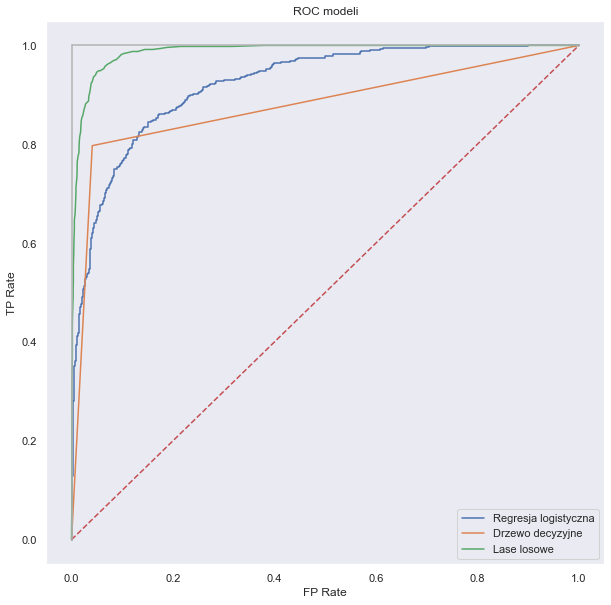

In [19]:
plt.subplots(1, figsize=(10,10))
plt.title('ROC modeli')
plt.plot(false_positive_rate1, true_positive_rate1,label='Regresja logistyczna')
plt.plot(false_positive_rate3, true_positive_rate3,label='Drzewo decyzyjne')
plt.plot(false_positive_rate5, true_positive_rate5,label='Lase losowe')
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.legend()
plt.ylabel('TP Rate')
plt.xlabel('FP Rate')

Teraz analizując ogólną istotność wszystkich zmiennych ze wszystkich modeli zaznaczamy, że 'Total_Trans_Amt', czyli suma wszystkich transakcji za ostatnie 12 miesięcy najmocniej wpływała na decyzje bankowe klienta. Jednak model regresji logistycznej nie pokazał istotności zmiennych, które były istotne znacznie w przypadku dwóch innych modeli. To są zzmienne dotyczące liczby wszystkich transakcji klienta, całkowite salda odnawialnego na karcie kredytowej, liczby zmiany transakcji kwartalnych.

Warto popatrzeć też na kroswalidację, czyli na to jak model funkcjonuje w podziale na 5 zbiorów. Jak widać jest jeszcze pole dla polepszenia modeli.

In [20]:
X.loc[:,numm_cols] = scaler.fit_transform(X.loc[:,numm_cols])

scores1 = cross_val_score(log_reg,X,y,cv=5)
scores2 = cross_val_score(dec_tree,X,y,cv=5)
scores3 = cross_val_score(random_f,X,y,cv=5)
print("Precyzja regresji log: %0.2f (+/- %0.2f)" % (scores1.mean(), scores1.std()))
print("Precyzja drzewa dec: %0.2f (+/- %0.2f)" % (scores2.mean(), scores2.std()))
print("Precyzja lasów los: %0.2f (+/- %0.2f)" % (scores3.mean(), scores3.std()))

Precyzja regresji log: 0.87 (+/- 0.07)
Precyzja drzewa dec: 0.90 (+/- 0.05)
Precyzja lasów los: 0.93 (+/- 0.05)
